In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nn.layers.transformer import Transformer
from nn.losses.classification import CategoricalCrossentropy
from nn.optimizers.first_order import GD

with open("data/resources/saved_datasets/tiny_shakespeare.txt", "r") as f:
    o = f.read().splitlines()

datastr = " ".join(o).lower()#[:100]
split = int(0.8 * len(datastr))
train = datastr[:split]
val   = datastr[split:]
vocab = sorted(list(set(datastr)))

def sample_data(example_len, data):
    start_idx = np.random.randint(len(data)-example_len)
    example = data[start_idx:start_idx+example_len]
    return np.array([vocab.index(c) for c in example])

def generate_batch(batch_size, block_size, data):
    data = np.array([sample_data(block_size+1, data) for _ in range(batch_size)])
    decoder_inputs = data[:, :-1]
    targets        = data[:, 1:]
    encoder_inputs = np.ones_like(decoder_inputs)
    return encoder_inputs, decoder_inputs, targets

block_size = 4 # sequence length
batch_size = 16 # h
d_model = 8 # dimesion of embedding
d_hidden = 4 # attention dimension
d_ff = 16 # FF projection dimension
n_heads = 2 # number of attention heads
n_layers = 2
vocab_size = len(vocab)
np.random.seed(1337)

model = Transformer(vocab_size, n_layers, n_heads, d_model, d_hidden, d_ff)
loss  = CategoricalCrossentropy()
optim = GD(model.parameters(), 1e-3)

print(model.n_params())

3574


In [2]:
history = {"train": [], "val": []}
for s in range(10000):
    optim.zero_grad()

    x_enc, x_dec, y = generate_batch(batch_size, block_size, train)
    y_pred = model([x_enc, x_dec])
    l = loss.calculate(y, y_pred)
    history["train"].append(l)

    model.backward(loss.backward())
    optim.step()

    if s % 500 == 0:
        #optim = GD(model.parameters(), optim.lr / 10)
        x_enc, x_dec, y = generate_batch(batch_size*10, block_size, val)
        y_pred = model([x_enc, x_dec])
        l = loss.calculate(y, y_pred)
        history["val"] += 500 * [l]
        print(f"step: {s}, train loss: {np.mean(history['train'][-500:]):.3f}, val loss: {l:.3f}")

print(f"min loss: {min(history['train'])}")

step: 0, train loss: 5.316, val loss: 5.396
step: 500, train loss: 3.727, val loss: 3.396
step: 1000, train loss: 3.320, val loss: 3.161
step: 1500, train loss: 3.187, val loss: 3.129
step: 2000, train loss: 3.105, val loss: 3.103
step: 2500, train loss: 3.071, val loss: 3.036
step: 3000, train loss: 3.035, val loss: 3.007
step: 3500, train loss: 3.018, val loss: 2.986
step: 4000, train loss: 2.998, val loss: 3.019
step: 4500, train loss: 2.986, val loss: 3.021
step: 5000, train loss: 2.974, val loss: 2.955
step: 5500, train loss: 2.960, val loss: 2.915
step: 6000, train loss: 2.961, val loss: 2.950
step: 6500, train loss: 2.939, val loss: 2.973
step: 7000, train loss: 2.933, val loss: 2.920
step: 7500, train loss: 2.928, val loss: 2.909
step: 8000, train loss: 2.916, val loss: 2.902
step: 8500, train loss: 2.913, val loss: 2.886
step: 9000, train loss: 2.912, val loss: 2.906
step: 9500, train loss: 2.905, val loss: 2.889
min loss: 2.5351911971809047


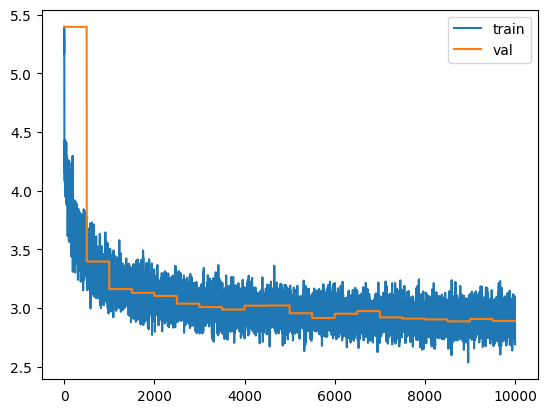

In [3]:
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()